# Capstone Project - The Battle of Neighborhoods Final

## 1.Introduction

### 1.1 Description of the Problem¶

We are well versed on development in london and how they have emerged has a most fine country in the world. London is known for pubs, restaurants, night life, industrial sector. However, we will concentrate on restaurant section which are increasing with varieties. The real deal is that as much as there are many fine restaurants in London – Asian, Middle Eastern, Latin and American restaurants, its very difficult to find good place to dine in the finest of indian cuisine that has combination of Malvani, konkani, punjabi style.

### 1.2 Background

Tadka, a successful restaurant chain in India is looking to expand operation into Europe through London. They want to create a high-end restaurant that comes with organic mix and healthy. Their target is not only Indians, but all communities which would like to taste something different. Since the London demography is so big, my client needs deeper insight from available data in other to decide where to establish the first Europe “palace” restaurant. This company spends a lot on research and provides customers with data insight into the ingredients used at restaurants.

### 1.3 Target Audience

Considering the diversity in London where most people are multireligion based. London is a place where different shades live. Most people resides in london are migrants where they come for job or education from india. Definetly, by looking at the population we can determine there is highly shortage of indian restaurants in London.

## 2. Data Preparation

### 2.1 Description of Data

This project will rely on public data from Wikipedia and Foursquare.

In this project, London will be used as synonymous to the "Greater London Area" in this project. Within the Greater London Area, there are areas that are within the London Area Postcode. The focus of this project will be the nieghbourhoods are that are within the London Post Code area. The London Area consists of 32 Boroughs and the "City of London". Our data will be from the link - Greater London Area <https://en.wikipedia.org/wiki/List_of_areas_of_London >

In [2]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium installed...
folium imported...
...Done


In [3]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [4]:
# Cleans html file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
# This extracts the "tbody" within the table where class is "wikitable sortable"
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [5]:
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')

In [6]:
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [7]:
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)

In [8]:
# Extracts every row with corresponding columns
# Then appends the values to the create pd dataframe "df"
# Please note that the first row (row[0]) is skipped because it is already the header
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [9]:
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [10]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [11]:
df.head()

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [12]:
##Remove [] under the Borough
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [13]:
df.shape

(533, 6)

In [14]:
df.head()

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


#### Data transformation:

Where the Postcode are more than one, (for example, in Acton, there are 2 postcodes - W3 and W4), the postcodes are spread to multi-rows and assigned the same values from the other columns

In [15]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [16]:
df0.head()

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [17]:
df0.shape

(637, 6)

As seen above, there are separate rows for Postcodes - W3and W4; same goes for the others too.
From the data, only the 'Location', 'Borough', 'Postcode', 'Post-town' will be used for this project. So they are extracted into a new data frame.

In [18]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [19]:
df1.head()

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [20]:
df1.shape

(637, 4)

Now, only the Boroughs with London Post-town will be used for our search of location. Therefore, all the non-post-town are dropped.

In [21]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [22]:
df21.head()

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [23]:
df21.shape

(381, 4)

In [24]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [25]:
df3.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [26]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

In [27]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [28]:
df_se.head()

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Denmark Hill,Southwark,SE5


focus on the demography of London where there are predominantly more multicultural groups.According to the proportion of races by London borough as seen in Demography of London, the top 5 Black Africans or Caribbeans are shown below:

In [34]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody


In [38]:
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [39]:
demo_london = pd.DataFrame(columns = columns1)

In [45]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [47]:
demo_london['Black'] = demo_london['Black'].astype('float')

In [48]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)

In [49]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


In [50]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

Just to be sure with syntax, Hackney is in North London, so it will not be returned. The resulting dataframe is df_se_top.

In [51]:
df_se_top.head()

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [52]:
df_se_top.shape

(38, 3)

In [53]:
df_se.shape

(65, 3)

In obtaining the location data of the locations, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.
These will help to create a new dataframe that will be used subsequently for the South East London areas.

In [54]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [57]:
df_se_loc = df_se_top

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]


In [58]:
# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [59]:
df_se_loc.head()

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [60]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [61]:
df_se_loc.shape

(38, 5)

## 3. Methodology


### 3.1 Data Exploration

In [63]:
# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [64]:
se_df.shape

(38, 5)

In [65]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49960,-0.09613
6,Bankside,Southwark,SE1,51.49960,-0.09613
7,Forest Hill,Lewisham,SE23,51.44122,-0.04764
8,Gipsy Hill,Lambeth,SE19,51.41990,-0.08808
9,Grove Park,Lewisham,SE12,51.44759,0.01350


In [66]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
16,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [67]:
se_df.loc[20, 'Location']

'Bellingham'

In [68]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Bellingham with postcode SE6, are 51.43722000000008, -0.018679999999960728.


In [70]:
CLIENT_ID = '3VNQTPNXCIDP5QPK5Z3Z0AVQUDZSNX3BMKNMQFKJNCPCDCZR' # Foursquare ID
CLIENT_SECRET = 'AUWBGWVTPWEWS3HNYKZNCFNQO4MOTRP24DKSTQWG3ZUFO2NH' # Foursquare Secret
VERSION = '20200327' # Foursquare API version

# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=3VNQTPNXCIDP5QPK5Z3Z0AVQUDZSNX3BMKNMQFKJNCPCDCZR&client_secret=AUWBGWVTPWEWS3HNYKZNCFNQO4MOTRP24DKSTQWG3ZUFO2NH&v=20200327&ll=51.43722000000008,-0.018679999999960728&radius=2000&limit=100'

In [71]:
results = requests.get(url).json()

From the results, the necessary information needs to be obtained from items key. To do this, the get_category_type function is used from the Foursquare lab.

In [72]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [73]:
#The result is then cleaned up from json to a structured pandas dataframe as shown below:

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [74]:
nearby_venues

,name,categories,lat,lng
0,Turkuaz,Turkish Restaurant,51.435320,-0.017902
1,Bottle Bar and Shop,Cocktail Bar,51.444867,-0.022616
2,Mekan,Greek Restaurant,51.443718,-0.020320
3,Blythe Hill Tavern,Pub,51.442362,-0.033809
4,Blythe Hill Fields,Park,51.446820,-0.035027
5,Catford Bridge Tavern,Pub,51.444529,-0.024407
6,Aldi,Supermarket,51.448675,-0.017781
7,Babur,Indian Restaurant,51.447390,-0.041831
8,Ladywell Fields,Park,51.453579,-0.020084
9,The Chandos,Pub,51.447659,-0.041181


In [75]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [76]:
nearby_venues_lewisham_unique.head()

,Count
Grocery Store,9
Park,6
Supermarket,6
Pub,4
Café,3


Interestingly, even though there are restaurants are the Lewisham area, they are not even in the top 5 venues. It should be noted that since we are limited by data availability, our perspectives will be on what we have.

In [77]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

70 venues were returned by Foursquare.


So in this case, 70 venues were returned for Lewisham.

Now let's explore (Multiple) Neighborhoods in the South East London area.

To do this, the function getNearbyVenues is used and it's created to repeat the same process for all neighborhoods.

In [78]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The created function - getNearbyVenues is then used on each neighbourhoods. And creates a new dataframe called london_venues.

In [81]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude'])

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Nunhead
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brockley
Camberwell
Catford
Chinbrook


In [82]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [83]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
2,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
3,Crofton Park,51.46268,-0.03558,Waterintobeer,51.463712,-0.038826,Beer Store
4,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant


In [85]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')



In [86]:
se_venue_unique_count.head(5)

,Count
Pub,347
Coffee Shop,242
Café,193
Park,170
Grocery Store,129


In [87]:
se_venue_unique_count.describe()

,Count
count,195.000000
mean,17.600000
std,38.354881
min,1.000000
25%,3.000000
50%,6.000000
75%,17.000000
max,347.000000


### 3.2 Clustering


For this section, the neighbourhoods in South East London will be clustered based on the processed data obtained above.

In [88]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [89]:
## The folium library is then used to obtain the coordinates.

map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [90]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [91]:
type(se_df)

pandas.core.frame.DataFrame

### Analysing Each Neighborhood

In [92]:
# one hot encoding
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [93]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [94]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [95]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Crofton Par

In [96]:
se_onehot.loc[se_onehot['Indian Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
4,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
136,Denmark

In [97]:

se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1483,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1484,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1485,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1486,Lewisham,0,

In [98]:
se_onehot.shape

(3432, 196)

Regrouping and Category Statistics


In [99]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Café,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,Nightclub,Observatory,Office,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Road,Rugby Pitch,Sake Bar,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.0,0.000000,0.0,0.0,0.010000,0.01,0.03,0.0,0.02,0.00,0.0,0.0,0.020000,0.020000,0.01,0.0,0.0,0.01,0.01,0.01,0.01,0.0,0.000000,0.01,0.02,0.0,0.000000,0.010000,0.0,0.0,0.01,0.000000,0.0,0.000000,0.020000,0.070000,0.0,0.0,0.000000,0.010000,0.0,0.0,0.01,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.0,0.010000,0.000000,0.010000,0.000000,0.0,0.020000,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.020000,0.010000,0.030000,0.0,0.0,0.000000,0.000000,0.000000,0.01,0.0,0.050000,0.01,0.00,0.01,0.000000,0.00,0.000000,0.000000,0.050000,0.000000,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.0,0.020000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.020000,0.050000,0.0,0.0,0.0,0.000000,0.020000,0.0,0.000000,0.0,0.000000,0.02,0.0,0.03,0.01,0.000000,0.000000,0.01,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.02,0.000000,0.0,0.0,0.02,0.000000,0.040000,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.01,0.0,0.01,0.000000,0.0,0.020000,0.0,0.0,0.0,0.000000
1,Bellingham,0.0,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.00

In [100]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (38, 5)
After One-hot encoding: (38, 196)


In [101]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [102]:
## Grouping of each Neighbourhoods with 10 common venues:

num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                  venue  freq
0           Coffee Shop  0.07
1                 Hotel  0.05
2                   Pub  0.05
3    Italian Restaurant  0.05
4               Theater  0.04
5            Art Museum  0.03
6    Seafood Restaurant  0.03
7  Gym / Fitness Center  0.03
8                Garden  0.02
9        Scenic Lookout  0.02


----Bellingham----
                  venue  freq
0         Grocery Store  0.13
1                  Park  0.10
2           Supermarket  0.08
3                   Pub  0.06
4                  Café  0.06
5    Italian Restaurant  0.04
6  Fast Food Restaurant  0.04
7           Coffee Shop  0.04
8                 Trail  0.03
9         Train Station  0.03


----Bermondsey----
                  venue  freq
0           Coffee Shop  0.07
1                 Hotel  0.05
2                   Pub  0.05
3    Italian Restaurant  0.05
4               Theater  0.04
5            Art Museum  0.03
6    Seafood Restaurant  0.03
7  Gym / Fitness Center  0.03
8          

                  venue  freq
0           Coffee Shop  0.07
1                 Hotel  0.05
2                   Pub  0.05
3    Italian Restaurant  0.05
4               Theater  0.04
5            Art Museum  0.03
6    Seafood Restaurant  0.03
7  Gym / Fitness Center  0.03
8                Garden  0.02
9        Scenic Lookout  0.02


----Nunhead----
                 venue  freq
0                  Pub  0.11
1                 Café  0.06
2          Pizza Place  0.05
3          Coffee Shop  0.05
4                 Park  0.05
5                  Bar  0.04
6            Gastropub  0.03
7          Art Gallery  0.03
8         Cocktail Bar  0.03
9  Indie Movie Theater  0.03


----Peckham----
                 venue  freq
0                  Pub  0.11
1                 Café  0.06
2          Pizza Place  0.05
3          Coffee Shop  0.05
4                 Park  0.05
5                  Bar  0.04
6            Gastropub  0.03
7          Art Gallery  0.03
8         Cocktail Bar  0.03
9  Indie Movie Theater  0

#### Creating new dataframe:


In [103]:
## Putting the common venues into pandas dataframe, the following return_most_common_venuesis used to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



In [104]:
##hen we create a new panda dataframe with 10 most common venues as shown below:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [105]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
1,Bellingham,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Coffee Shop,Fast Food Restaurant,Train Station,Trail
2,Bermondsey,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
3,Blackheath,Pub,Grocery Store,Park,Coffee Shop,Garden,Bakery,Italian Restaurant,Supermarket,Clothing Store,Café
4,Brockley,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant


In [106]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [107]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

#### Clustering of Neighbourhoods


In [108]:
## The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the neighbourhood into 5 clusters.

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 4, 3, 1, 2, 0, 0, 1, 2], dtype=int32)

In [109]:
kmeans.labels_[0:10]

array([4, 0, 4, 3, 1, 2, 0, 0, 1, 2], dtype=int32)

In [110]:
##Now creating a new dataframe that includes the clusters as well as the top 10 venues for each neighbourhoods.

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [111]:
se_merged = se_df

In [112]:
se_merged.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [113]:
# match/merge SE London data with latitude/longitude for each neighborhood
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [114]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,2,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Brewery,Pizza Place,Bar
2,Deptford,Lewisham,SE8,51.48114,-0.02467,1,Pub,Café,Coffee Shop,Bar,Park,Brewery,Trail,Indie Movie Theater,Italian Restaurant,Indian Restaurant
3,Dulwich,Southwark,SE21,51.44100,-0.08897,3,Pub,Café,Park,Coffee Shop,Grocery Store,Bakery,Gym / Fitness Center,Farmers Market,Pizza Place,Brewery
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,1,Pub,Café,Pizza Place,Italian Restaurant,Park,Coffee Shop,Gastropub,Burger Joint,Garden Center,Platform


In [115]:
se_clusters = se_merged_latlong

#### Please note, that the number of clusters was chosen as 5 for initial run.

Optimal Number of Clusters for K-mean


To get the optimal number of clusters to be used for the K-mean, there are a number ways possible for the evaluation. Therefore, in this task, the following are used:
    
    1. Elbow (Criterion) Method 2. Silhouette Coefficient 

1. Elbow Method

The elbow method is used to solve the problem of selecting k. Interestingly, the elbow method is not perfect either but it gives significant insight that is perhaps not top optimal but sub-optimal to choosing the optimal number of clusters by fitting the model with a range of values for k.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE.

In [116]:
%matplotlib inline
import matplotlib
import numpy as np

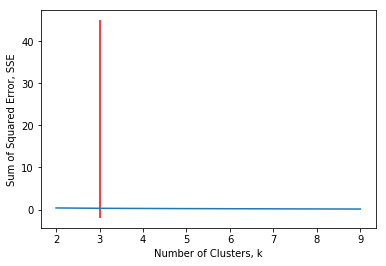

In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

Depending on the number of iteration (in this case, 500 iterations were used), the number of cluster, k is 3.

2. Silhouette Coefficient

To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [118]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.5755039467549873
Where n_clusters = 3, the Silhouette Coefficient is 0.5858620332498141
Where n_clusters = 4, the Silhouette Coefficient is 0.6350832723641994
Where n_clusters = 5, the Silhouette Coefficient is 0.6461587982308613
Where n_clusters = 6, the Silhouette Coefficient is 0.6971297289227137
Where n_clusters = 7, the Silhouette Coefficient is 0.8151579262180803
Where n_clusters = 8, the Silhouette Coefficient is 0.8911210650811175
Where n_clusters = 9, the Silhouette Coefficient is 0.9439707205975127


In [119]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

#### Visualizing the Resulting Clusters


In [120]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

Cluster 1

In [121]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Lewisham,0,Pub,Grocery Store,Park,Café,Supermarket,Gym / Fitness Center,Italian Restaurant,Indian Restaurant,Train Station,Fast Food Restaurant
15,Lewisham,0,Pub,Grocery Store,Park,Café,Supermarket,Gym / Fitness Center,Italian Restaurant,Indian Restaurant,Train Station,Fast Food Restaurant
20,Lewisham,0,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Coffee Shop,Fast Food Restaurant,Train Station,Trail
26,Lewisham,0,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Coffee Shop,Fast Food Restaurant,Train Station,Trail
36,Lewisham,0,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Coffee Shop,Fast Food Restaurant,Train Station,Trail
37,Lewisham,0,Pub,Grocery Store,Park,Café,Supermarket,Gym / Fitness Center,Italian Restaurant,Indian Restaurant,Train Station,Fast Food Restaurant


Cluster 2

In [123]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,1,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
2,Lewisham,1,Pub,Café,Coffee Shop,Bar,Park,Brewery,Trail,Indie Movie Theater,Italian Restaurant,Indian Restaurant
4,Southwark,1,Pub,Café,Pizza Place,Italian Restaurant,Park,Coffee Shop,Gastropub,Burger Joint,Garden Center,Platform
11,Lewisham,1,Pub,Café,Gastropub,Park,Garden,Food Truck,Fish & Chips Shop,Coffee Shop,Restaurant,Gym
13,Lewisham,1,Coffee Shop,Pub,Café,Park,Gastropub,Bar,Indian Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
16,Lewisham,1,Pub,Café,Gastropub,Park,Garden,Food Truck,Fish & Chips Shop,Coffee Shop,Restaurant,Gym
17,Lewisham,1,Pub,Coffee Shop,Café,Bar,Italian Restaurant,Park,Indian Restaurant,Gastropub,Brewery,African Restaurant
19,Southwark,1,Pub,Café,Coffee Shop,Pizza Place,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
21,Southwark,1,Pub,Café,Coffee Shop,Pizza Place,Park,Bar,Gastropub,Burger Joint,Cocktail Bar,Italian Restaurant
22,Southwark,1,Pub,Brewery,Coffee Shop,Park,Bar,Café,Food Truck,Gym / Fitness Center,Vietnamese Restaurant,Beer Bar


Cluster 3

In [124]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,2,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Brewery,Pizza Place,Bar
10,Lambeth,2,Coffee Shop,Pub,Café,Brewery,Market,Pizza Place,Cocktail Bar,Burger Joint,Caribbean Restaurant,Restaurant
29,Lambeth,2,Coffee Shop,Pub,Café,Brewery,Market,Pizza Place,Cocktail Bar,Burger Joint,Caribbean Restaurant,Restaurant
35,Southwark,2,Café,Coffee Shop,Park,Pub,Italian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Brewery,Pizza Place,Bar


Cluster 4

In [125]:
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Southwark,3,Pub,Café,Park,Coffee Shop,Grocery Store,Bakery,Gym / Fitness Center,Farmers Market,Pizza Place,Brewery
7,Lewisham,3,Pub,Coffee Shop,Café,Park,Grocery Store,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
8,Lambeth,3,Pub,Park,Coffee Shop,Italian Restaurant,Grocery Store,Café,Train Station,Gastropub,Bakery,Breakfast Spot
12,Lewisham,3,Pub,Coffee Shop,Café,Park,Grocery Store,Supermarket,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pharmacy
23,Croydon,3,Pub,Grocery Store,Café,Supermarket,Coffee Shop,Park,Tram Station,African Restaurant,Plaza,Caribbean Restaurant
25,Croydon,3,Pub,Grocery Store,Café,Supermarket,Coffee Shop,Park,Tram Station,African Restaurant,Plaza,Caribbean Restaurant
30,Croydon,3,Pub,Park,Coffee Shop,Italian Restaurant,Grocery Store,Café,Train Station,Gastropub,Bakery,Breakfast Spot
32,Lewisham,3,Pub,Grocery Store,Park,Coffee Shop,Garden,Bakery,Italian Restaurant,Supermarket,Clothing Store,Café
33,Lambeth,3,Pub,Grocery Store,Coffee Shop,Café,Bakery,Park,Pizza Place,Gym / Fitness Center,Italian Restaurant,Pharmacy


Cluster 5

In [126]:
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,4,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
6,Southwark,4,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
14,Lambeth,4,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
18,Southwark,4,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant
24,Southwark,4,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Seafood Restaurant,Gym / Fitness Center,Art Museum,Garden,Tapas Restaurant


### 4. Result

The following are the highlights of the 5 clusters above:
1] Pubs, Grocery Stores are popular in the South East London.
2] As for restaurants, the Italian Restaurants are very popular in the South East London area. Especially in Southwark and Lambeth areas.
3] With the Lewisham area being the most condensed area of Indian Restaurant in the South East Area, it is surprising to see how in the top 10 venues, you can barely see restaurants in the top 5 venues.
4] Although, the Clusters have variations, a very visible presence is the predominance of pubs.

### 5. Discussion and Conclusion

Its been visible from cluster 3 and 4 that Indian Restaurant can play vital role in Restaurant competition and very good chance to set up. Their proximity to other amenities and accessibility to station are huge. These 2 clusters do not have top restaurants that could rival their standards if they are created. And the chances to resources needed is quite high as Lewisham and Lambeth.
In conclusion, this project would have had better results if there were more data in terms of per capita income data within the area, traffic access, corporates of more venues exploration with the Foursquare.
Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.